In [1]:
# Run this cell just once! (or restart Kernel before second time)

import os
os.chdir('..')

In [11]:
import fastText
import re
import pandas as pd
from utils.fixed import *
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
from heapq import nlargest, nsmallest
import numpy as np
import pickle


%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['lines.linewidth'] = 2

In [9]:
def create_teams_dataframes(match_df,team1,team2):
    team1_df = match_df[match_df.team == team1].sort_values(by=['tweetCreated'])
    team2_df = match_df[match_df.team == team2].sort_values(by=['tweetCreated'])
    team1_df = team1_df.drop_duplicates(subset=['tweetID', 'tweetText', 'tweetRetweetCt', 'tweetFavoriteCt',
       'tweetSource', 'tweetCreated', 'userID', 'userScreen', 'userName',
       'userCreateDt', 'userDesc', 'userFollowerCt', 'userFriendsCt',
       'userLocation', 'userTimezone']).reset_index(drop=True)
    team2_df = team2_df.drop_duplicates(subset=['tweetID', 'tweetText', 'tweetRetweetCt', 'tweetFavoriteCt',
       'tweetSource', 'tweetCreated', 'userID', 'userScreen', 'userName',
       'userCreateDt', 'userDesc', 'userFollowerCt', 'userFriendsCt',
       'userLocation', 'userTimezone']).reset_index(drop=True)
    return team1_df, team2_df

def calculate_sentiment_df(team_df):
    index=pd.DatetimeIndex(team_df['tweetCreated'])
    time_period=team_df['tweetCreated'].apply(lambda x: datetime.datetime.strftime(x,'%H:%M')).tolist()
    sent_df=pd.DataFrame(index=index,data=time_period,columns=['time_period'])
    sent_df['sentiment'] = np.array(list(team_df['sentiment']))
    count_df = sent_df.groupby(by=['time_period'],as_index=False).count()
    sent_df = sent_df.groupby(by=['time_period'],as_index=False).sum() 
    return sent_df,count_df

def select_peaks(signal,n=5):
    peaks_positive,_ = find_peaks(signal,height=0)
    peaks_negative,_ = find_peaks(-signal,height=0)
    signal_array=np.array(list(signal))
    maximas = nlargest(n, zip(signal_array[peaks_positive],peaks_positive))
    minimas = nsmallest(n, zip(signal_array[peaks_negative],peaks_negative))
    peaks_temp = maximas+minimas
    peaks=[]
    for i, j in peaks_temp:
        peaks.append((j,i))
    return peaks

def plot_sentiment(sentiment_df, peaks, annotation_size=15,distance=4,title='',filename = ''):
    sentiment_df.plot(legend=None)
    for i in range(len(peaks)):
        max_ann=peaks[i]
        if (peaks[i][1]<0):
            font_color='red'
            distance=-distance
        else:
            font_color='green'
        plt.annotate(str(peaks[i][0]), xy=max_ann, xytext=(peaks[i][0],peaks[i][1]+distance), size=annotation_size, color=font_color)
    plt.title(title,size=25)
    if filename!='':
        fig_path = os.path.join(MAIN_PATH,RESULTS_PATH,filename)
        plt.savefig(fig_path)
    plt.show()
            
def draw_worcloud(text,filename):
    fig_path = os.path.join(MAIN_PATH,RESULTS_PATH,filename)
    wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fig_path)
    plt.show()

### LOAD DATA

In [4]:
MATCH="MAN-NEW"
SLANG_DICT=load_slang(SLANG_PATH)
file_path, team1, team2, match_start, first_part_end, \
    second_part_start, match_end, hashtags_team1, hashtags_team2 = load_match_data(MATCH)
tweets_df=create_match_df(MATCH)

### CREATE DIRECTORY FOR ANALYSIS RESULTS

In [5]:
MATCH_RESULT_PATH = os.path.join(MAIN_PATH,RESULTS_PATH,MATCH)
if not os.path.exists(MATCH_RESULT_PATH):
    os.makedirs(MATCH_RESULT_PATH)

In [83]:
# def check_hashtags(text,hashtags_team1,hashtags_team2):
#     pattern1='|'.join(hashtags_team1)+'|#totliv|#psgliv'
#     pattern2='|'.join(hashtags_team2)+'|#totliv|#psgliv'
#     if bool(re.findall(pattern1,text,re.IGNORECASE)) & bool(re.findall(pattern2,text,re.IGNORECASE)):
#         return 0
#     else:
#         return 1
    
    
# tweets_df['hashtag_check']=tweets_df['tweetText'].apply(lambda x: check_hashtags(x,hashtags_team1,hashtags_team2))

In [84]:
#tweets_df=tweets_df[tweets_df['hashtag_check']==1]

# DRAW WORDCLOUD

### TWEETS PREPROCESSING FOR WORDCLOUD (removing stopwords and short words)

In [53]:
remove_stopwords = True
remove_shortwords = True
X_not_stemmed = get_processed_tweets(tweets_df, SLANG_DICT, remove_stopwords, remove_shortwords, stemmed = False, labels=False)
X_stemmed = get_processed_tweets(tweets_df, SLANG_DICT, remove_stopwords, remove_shortwords, stemmed = True, labels = False)

###  WORDCLOUD WITHOUT STEMMING

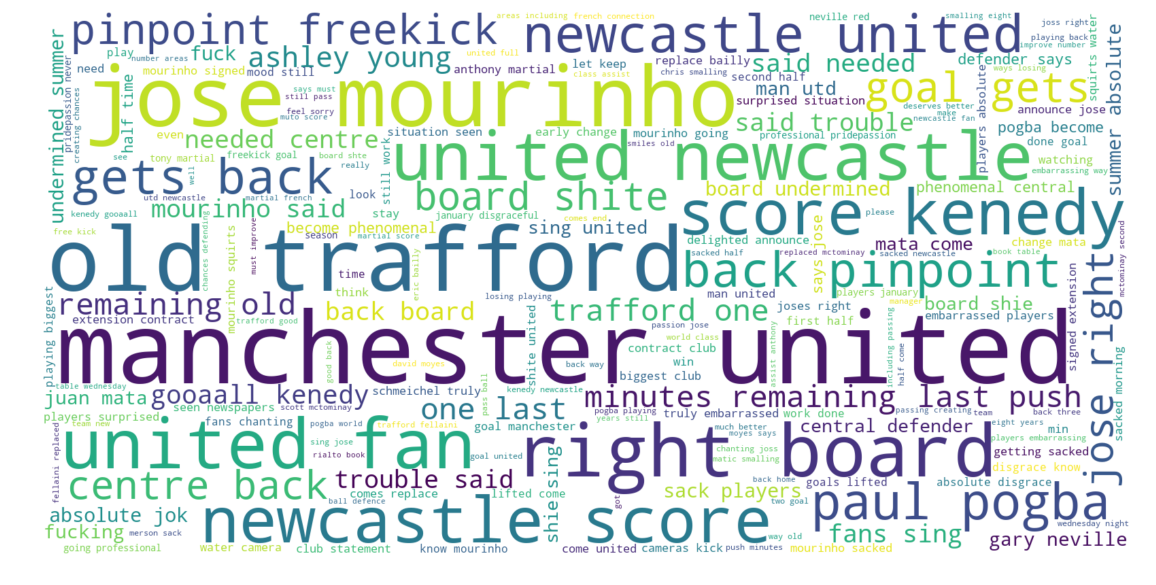

In [11]:
corpus = tweets_to_text(X_not_stemmed)
draw_worcloud(corpus,MATCH+'_wordcloud-not-stemmed.png')

### WORDCLOUD AFTER STEMMING

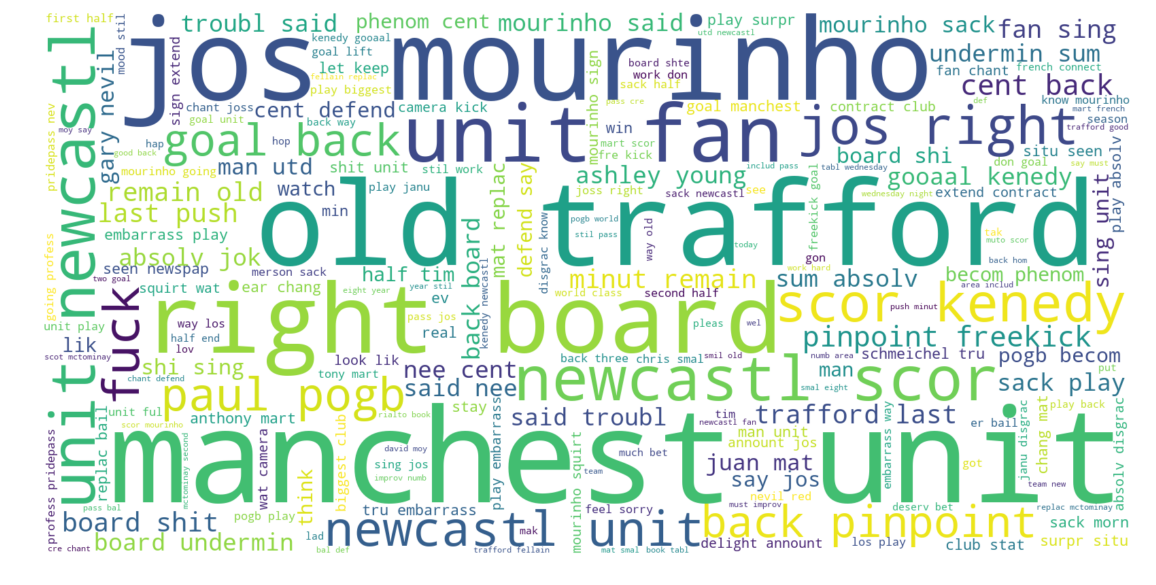

In [54]:
corpus_stemmed = tweets_to_text(X_stemmed)
draw_worcloud(corpus_stemmed,MATCH+'_wordcloud-stemmed.png')

# SENTIMENT PREDICTION

### PREPARE DATA

In [6]:
X = get_processed_tweets(tweets_df, SLANG_DICT, remove_stopwords = False, remove_shortwords = False, stemmed = True, labels=False) 
indexes = list(tweets_df.index)

 ### LOGISTIC REGRESSION

In [7]:
clf_name='logreg'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'logistic-regression.pkl' )
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df,team1,team2)

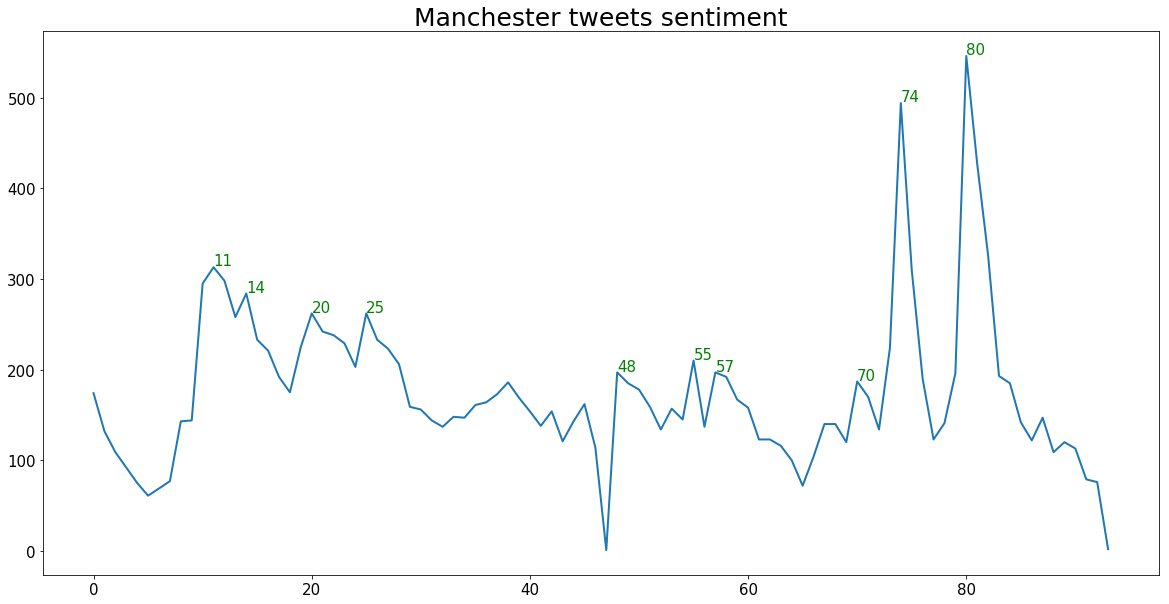

In [12]:
team1_sent,team1_count=calculate_sentiment_df(team1_df)
sent_peaks_team1=select_peaks(team1_sent['sentiment'],n=10)
count_peaks_team1=select_peaks(team1_count['sentiment'],n=10)
plot_sentiment(team1_sent,sent_peaks_team1,distance=2,title=team1+ " tweets sentiment", filename=team1+'-sent-'+clf_name+'.jpg')

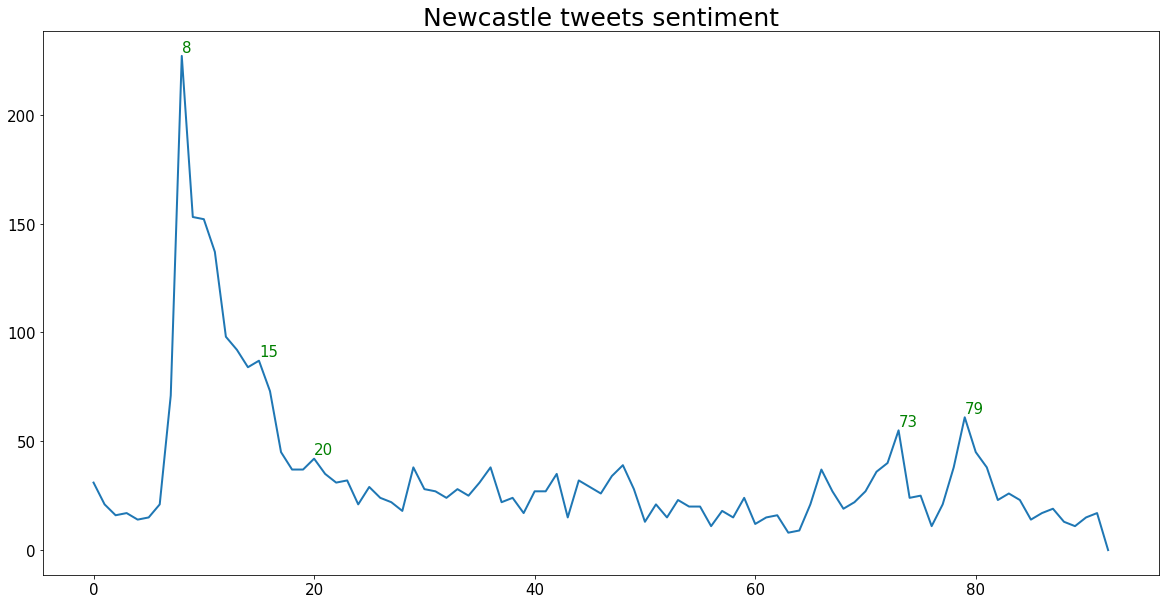

In [14]:
team2_sent,team2_count=calculate_sentiment_df(team2_df)
sent_peaks_team2=select_peaks(team2_sent['sentiment'])
count_peaks_team2=select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent,sent_peaks_team2,distance=2,title=team2+ " tweets sentiment",filename=team2+'-sent-'+clf_name+'.jpg')

### LINEAR SVC

In [23]:
clf_name='svc'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'linearSVC.pkl' )
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df,team1,team2)

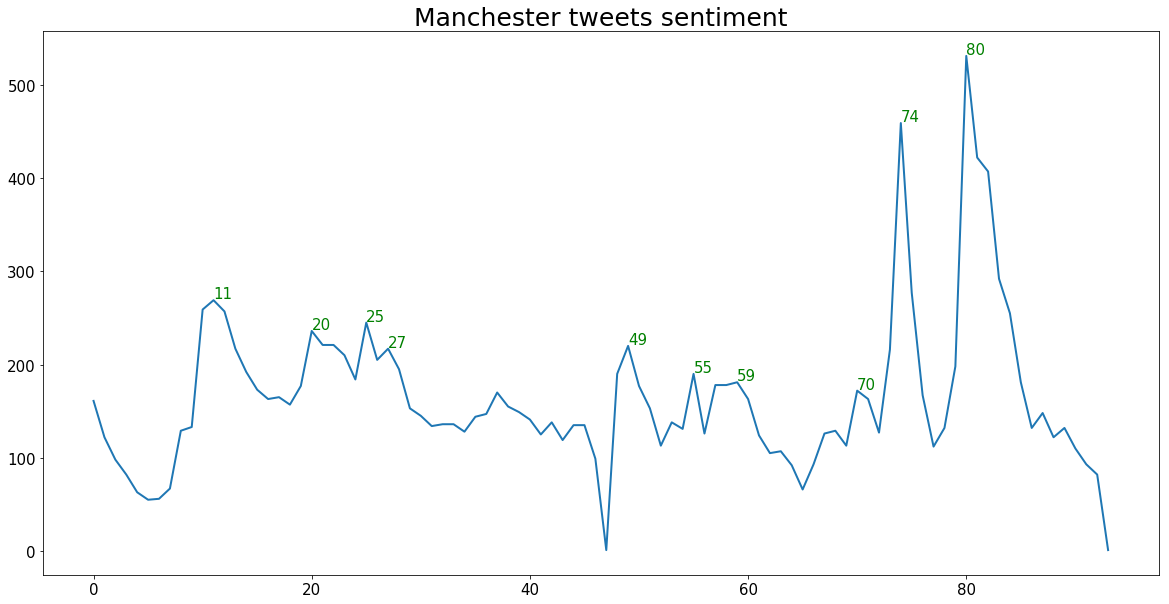

In [24]:
team1_sent,team1_count=calculate_sentiment_df(team1_df)
sent_peaks_team1=select_peaks(team1_sent['sentiment'],n=10)
count_peaks_team1=select_peaks(team1_count['sentiment'],n=10)
plot_sentiment(team1_sent,sent_peaks_team1,distance=2,title=team1+ " tweets sentiment", filename=team1+'-sent-'+clf_name+'.jpg')

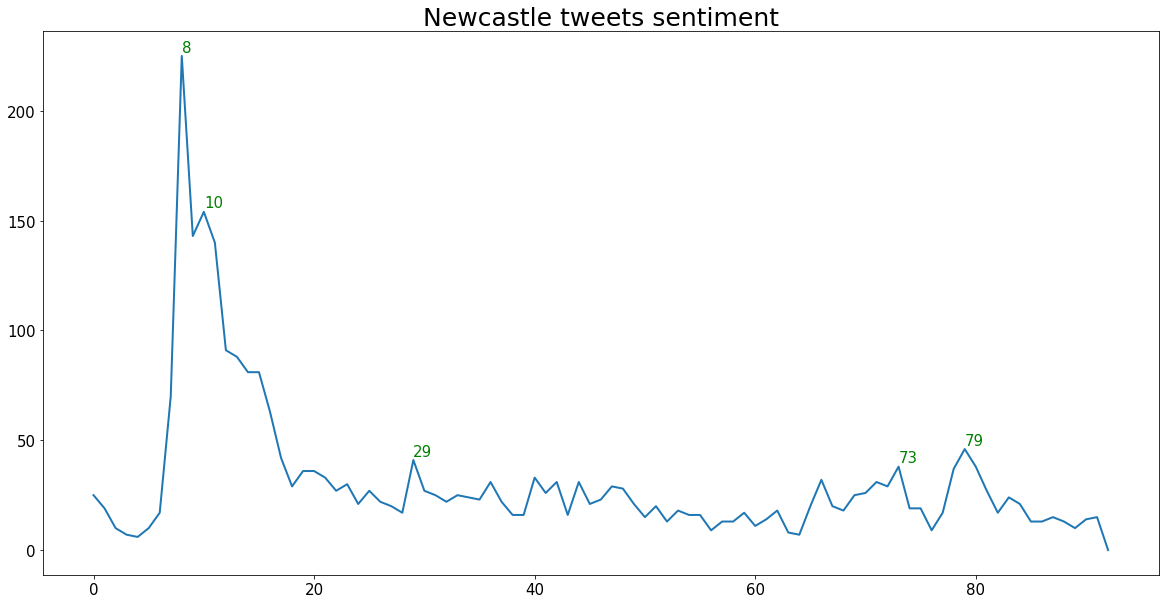

In [25]:
team2_sent,team2_count=calculate_sentiment_df(team2_df)
sent_peaks_team2=select_peaks(team2_sent['sentiment'])
count_peaks_team2=select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent,sent_peaks_team2,distance=2,title=team2+ " tweets sentiment",filename=team2+'-sent-'+clf_name+'.jpg')

### BERNOULLI NB

In [26]:
clf_name='bnb'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'BernoulliNB.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df,team1,team2)

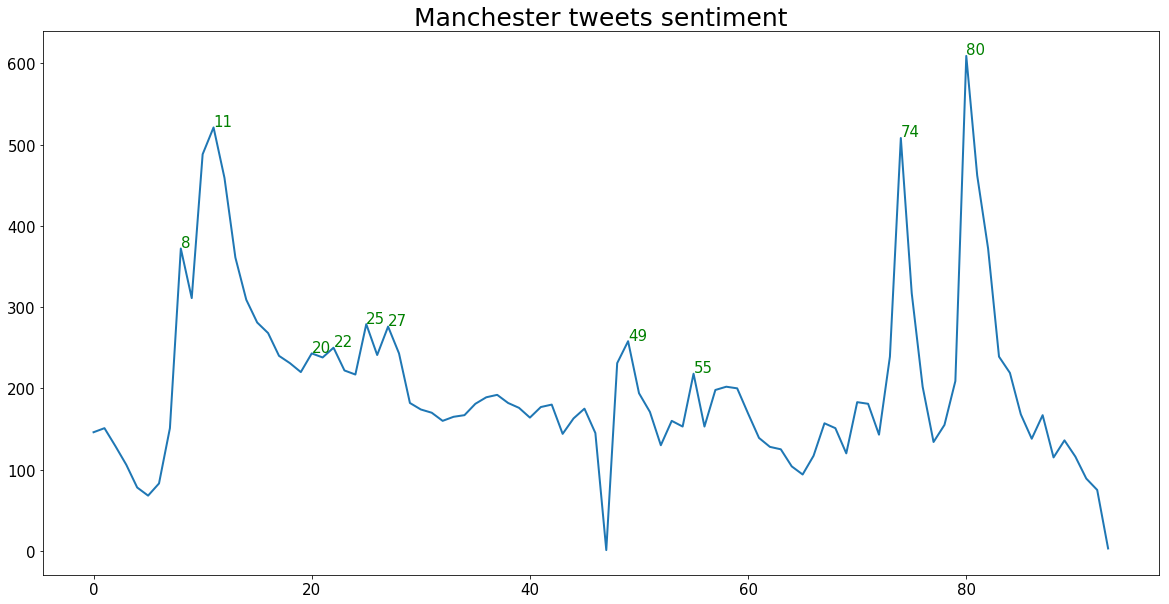

In [27]:
team1_sent,team1_count=calculate_sentiment_df(team1_df)
sent_peaks_team1=select_peaks(team1_sent['sentiment'],n=10)
count_peaks_team1=select_peaks(team1_count['sentiment'],n=10)
plot_sentiment(team1_sent,sent_peaks_team1,distance=2,title=team1+ " tweets sentiment", filename=team1+'-sent-'+clf_name+'.jpg')

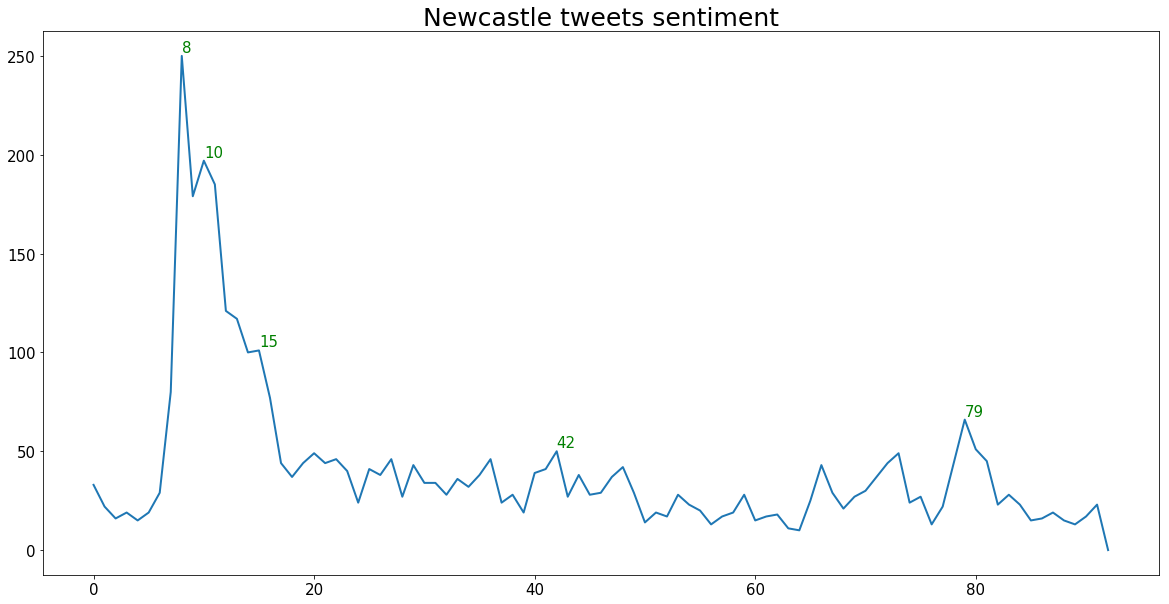

In [28]:
team2_sent,team2_count=calculate_sentiment_df(team2_df)
sent_peaks_team2=select_peaks(team2_sent['sentiment'])
count_peaks_team2=select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent,sent_peaks_team2,distance=2,title=team2+ " tweets sentiment",filename=team2+'-sent-'+clf_name+'.jpg')

### MULTINOMIAL NB

In [29]:
clf_name='mnb'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'multinomialNB.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df,team1,team2)

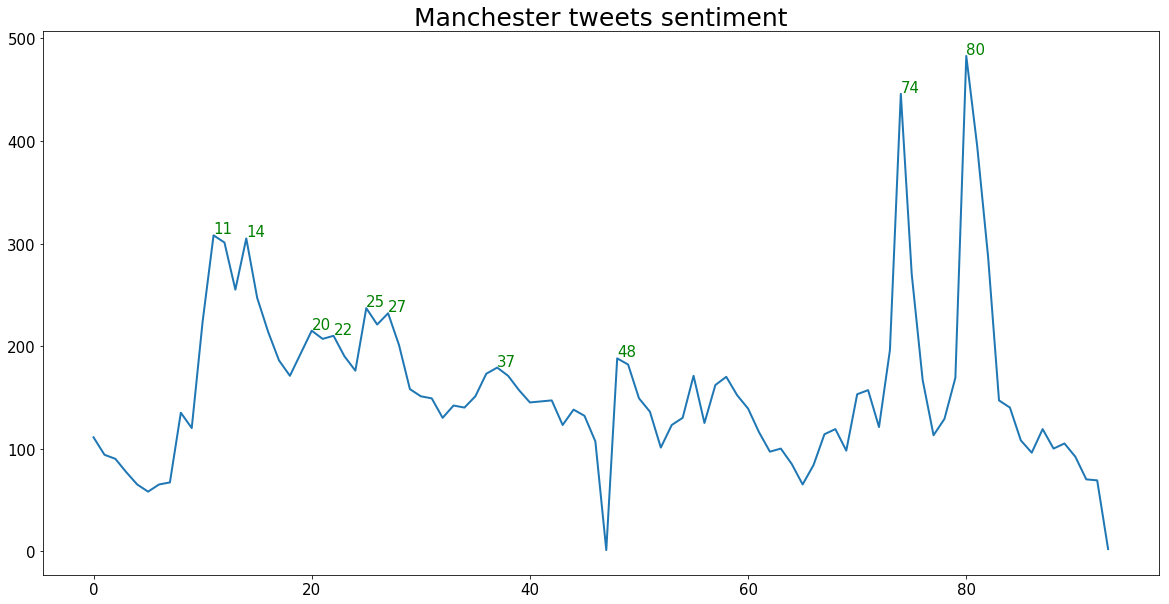

In [31]:
team1_sent,team1_count=calculate_sentiment_df(team1_df)
sent_peaks_team1=select_peaks(team1_sent['sentiment'],n=10)
count_peaks_team1=select_peaks(team1_count['sentiment'],n=10)
plot_sentiment(team1_sent,sent_peaks_team1,distance=2,title=team1+ " tweets sentiment", filename=team1+'-sent-'+clf_name+'.jpg')

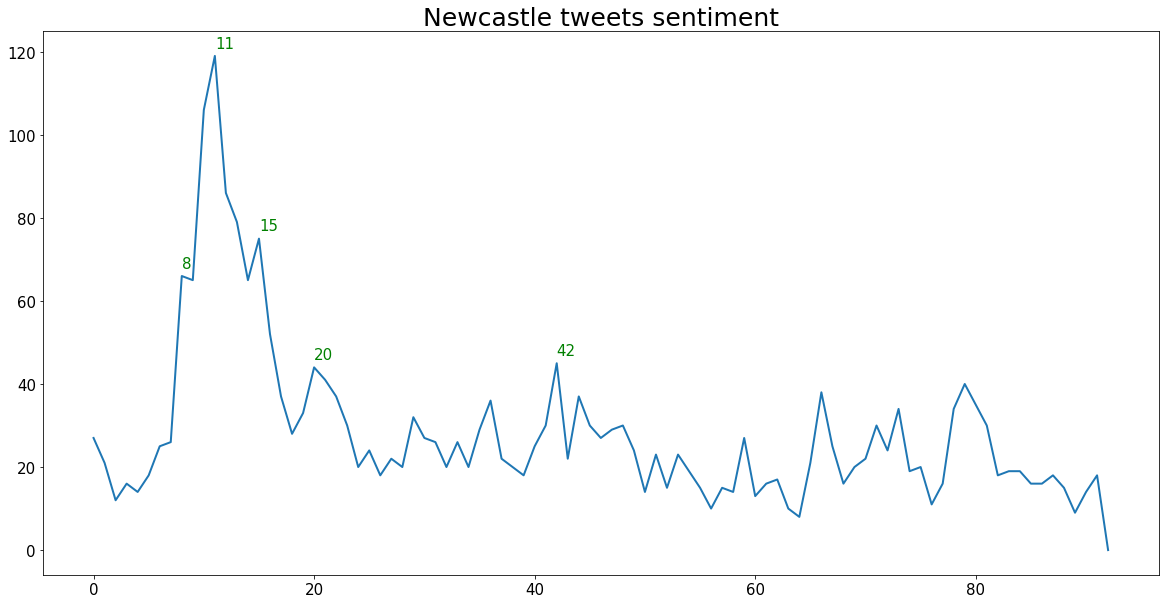

In [32]:
team2_sent,team2_count=calculate_sentiment_df(team2_df)
sent_peaks_team2=select_peaks(team2_sent['sentiment'])
count_peaks_team2=select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent,sent_peaks_team2,distance=2,title=team2+ " tweets sentiment",filename=team2+'-sent-'+clf_name+'.jpg')

### XGBOOST

In [34]:
clf_name='xgb'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'XGBClassifier.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df,team1,team2)

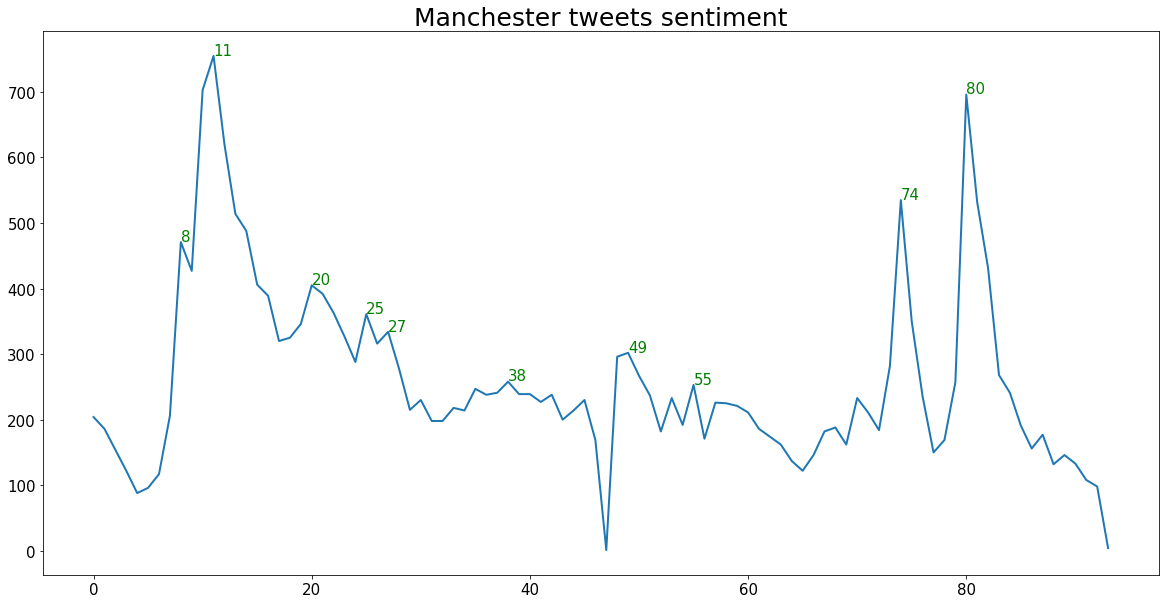

In [35]:
team1_sent,team1_count=calculate_sentiment_df(team1_df)
sent_peaks_team1=select_peaks(team1_sent['sentiment'],n=10)
count_peaks_team1=select_peaks(team1_count['sentiment'],n=10)
plot_sentiment(team1_sent,sent_peaks_team1,distance=2,title=team1+ " tweets sentiment", filename=team1+'-sent-'+clf_name+'.jpg')

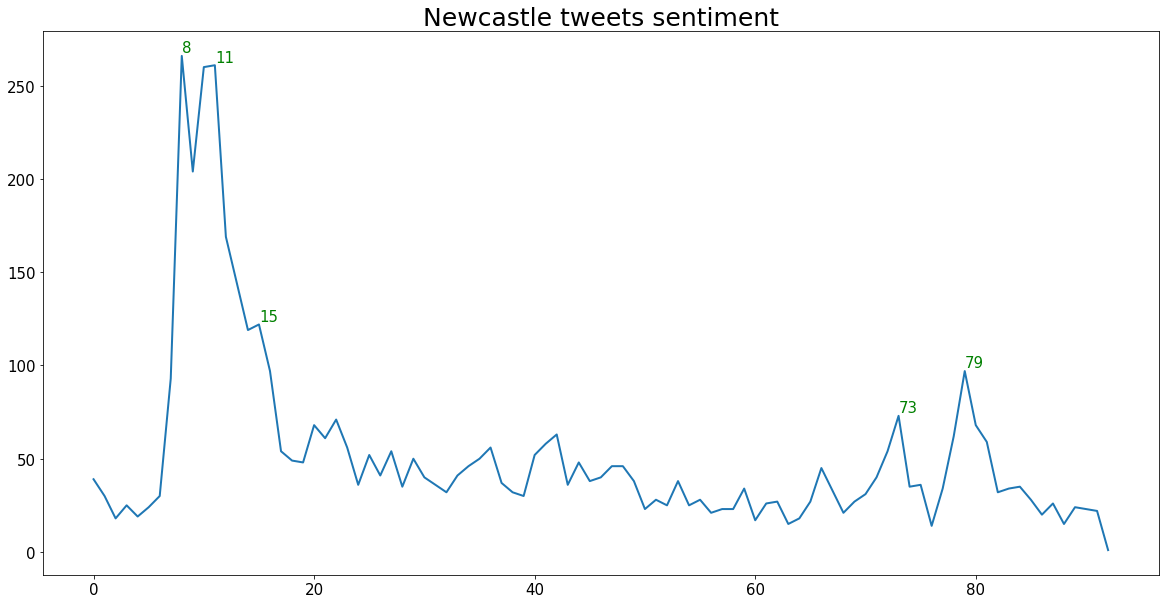

In [36]:
team2_sent,team2_count=calculate_sentiment_df(team2_df)
sent_peaks_team2=select_peaks(team2_sent['sentiment'])
count_peaks_team2=select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent,sent_peaks_team2,distance=2,title=team2+ " tweets sentiment",filename=team2+'-sent-'+clf_name+'.jpg')

### SVC WITH FEATURES SELECTION

In [37]:
clf_name='svc-selection'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'SVC-with-selection.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df,team1,team2)

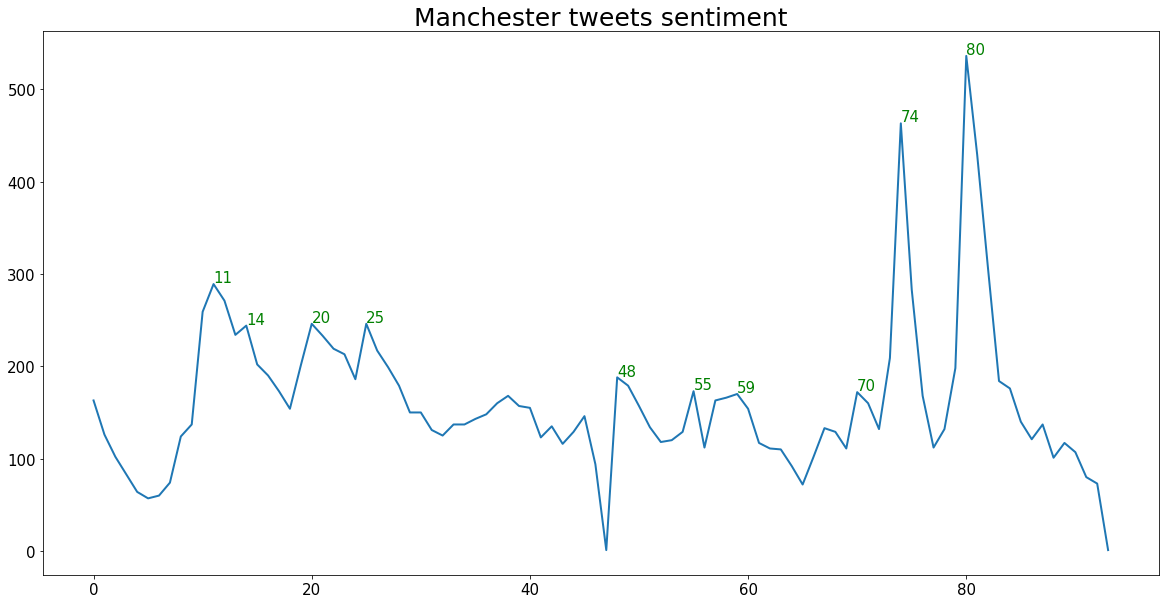

In [38]:
team1_sent,team1_count=calculate_sentiment_df(team1_df)
sent_peaks_team1=select_peaks(team1_sent['sentiment'],n=10)
count_peaks_team1=select_peaks(team1_count['sentiment'],n=10)
plot_sentiment(team1_sent,sent_peaks_team1,distance=2,title=team1+ " tweets sentiment", filename = team1+'-sent-'+clf_name+'.jpg')

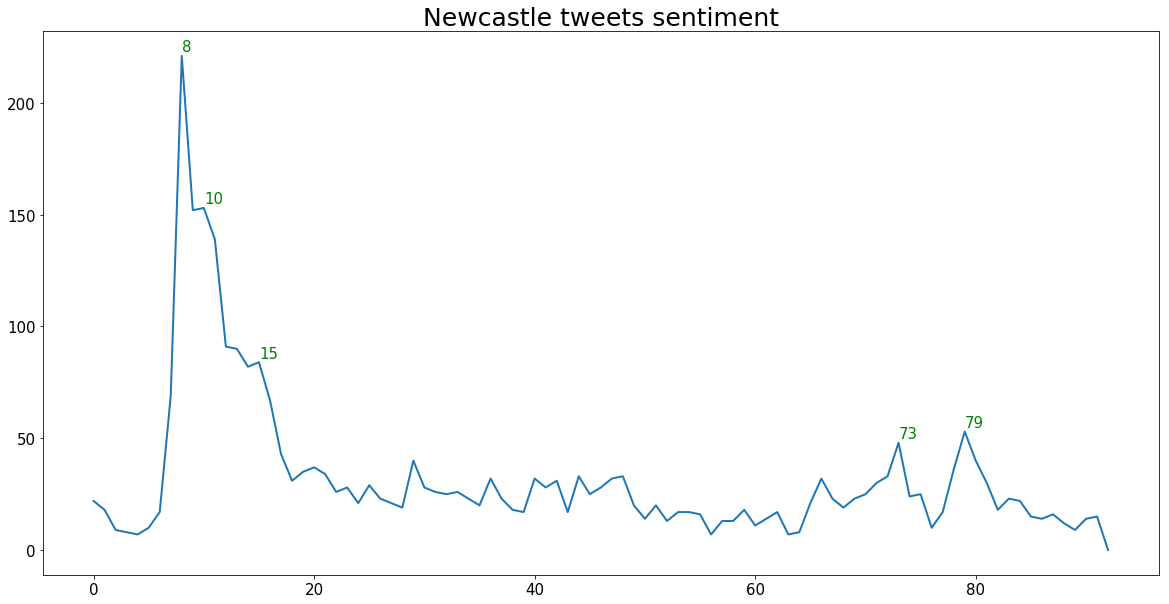

In [39]:
team2_sent,team2_count=calculate_sentiment_df(team2_df)
sent_peaks_team2=select_peaks(team2_sent['sentiment'])
count_peaks_team2=select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent,sent_peaks_team2,distance=2,title=team2+ " tweets sentiment",filename=team2+'-sent-'+clf_name+'.jpg')

# FASTTEXT PREDICTION

In [46]:
clf_name = 'fasttext'
fasttext_model_path = os.path.join(MAIN_PATH,MODEL_PATH,'fasttext.model')
model=fastText.load_model(fasttext_model_path)

### PREDICTION

In [47]:
labels=model.predict(X)

### PREPARE SENTIMENT LABELS

In [48]:
sentiment=[int(labels[0][i][0].replace('__label__','').replace('0','-1')) for i in range(len(labels[0]))]
tweets_df['sentiment']= sentiment

### SPLIT DATA INTO TEAMS DATAFRAMES

In [49]:
team1_df, team2_df = create_teams_dataframes(tweets_df,team1,team2)

## *FIRST TEAM SENTIMENT*

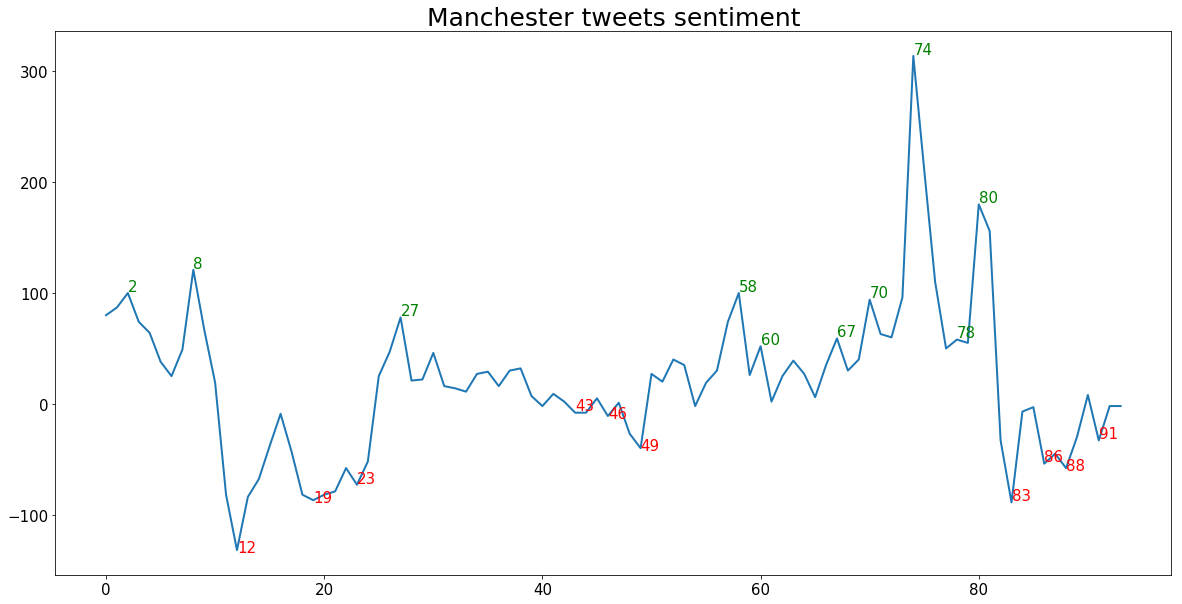

In [50]:
team1_sent,team1_count=calculate_sentiment_df(team1_df)
sent_peaks_team1=select_peaks(team1_sent['sentiment'],n=10)
count_peaks_team1=select_peaks(team1_count['sentiment'],n=10)
plot_sentiment(team1_sent,sent_peaks_team1,distance=2,title=team1+ " tweets sentiment", filename=team1+'-sent-'+clf_name+'.jpg')

## *SECOND TEAM SENTIMENT*

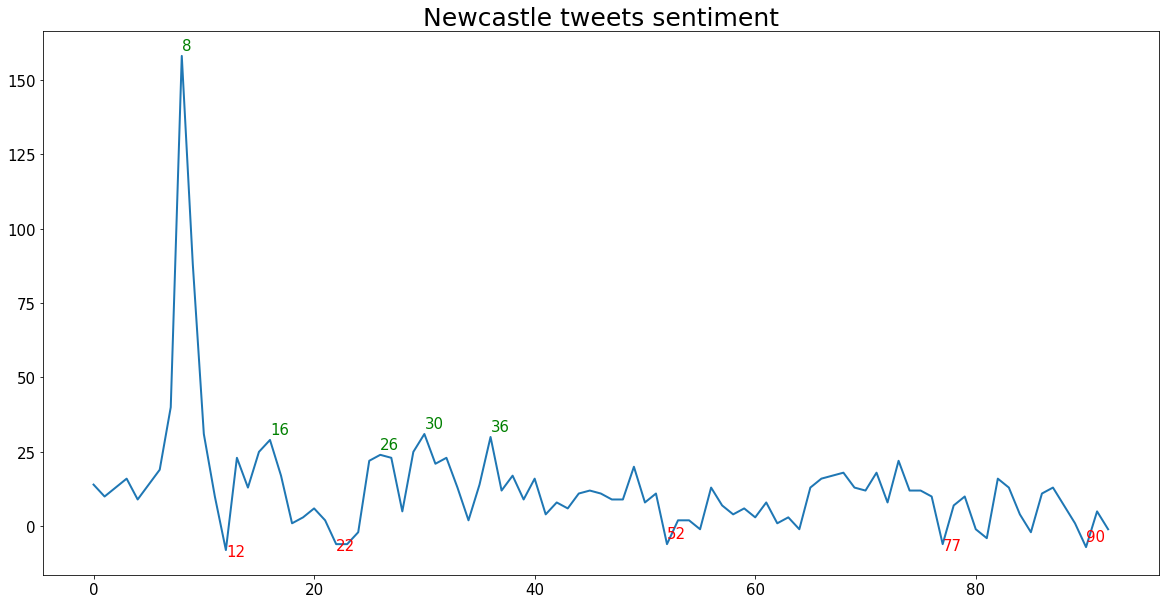

In [51]:
team2_sent,team2_count=calculate_sentiment_df(team2_df)
sent_peaks_team2=select_peaks(team2_sent['sentiment'])
count_peaks_team2=select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent,sent_peaks_team2,distance=2,title=team2+ " tweets sentiment",filename=team2+'-sent-'+clf_name+'.jpg')

# TWEETS COUNT OVER THE TIME

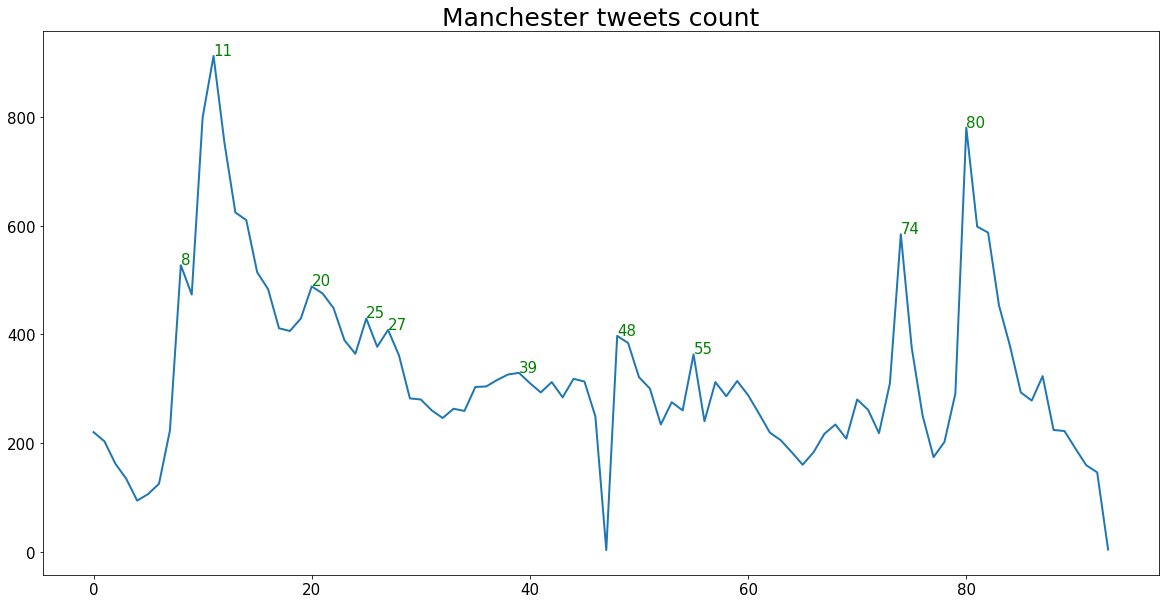

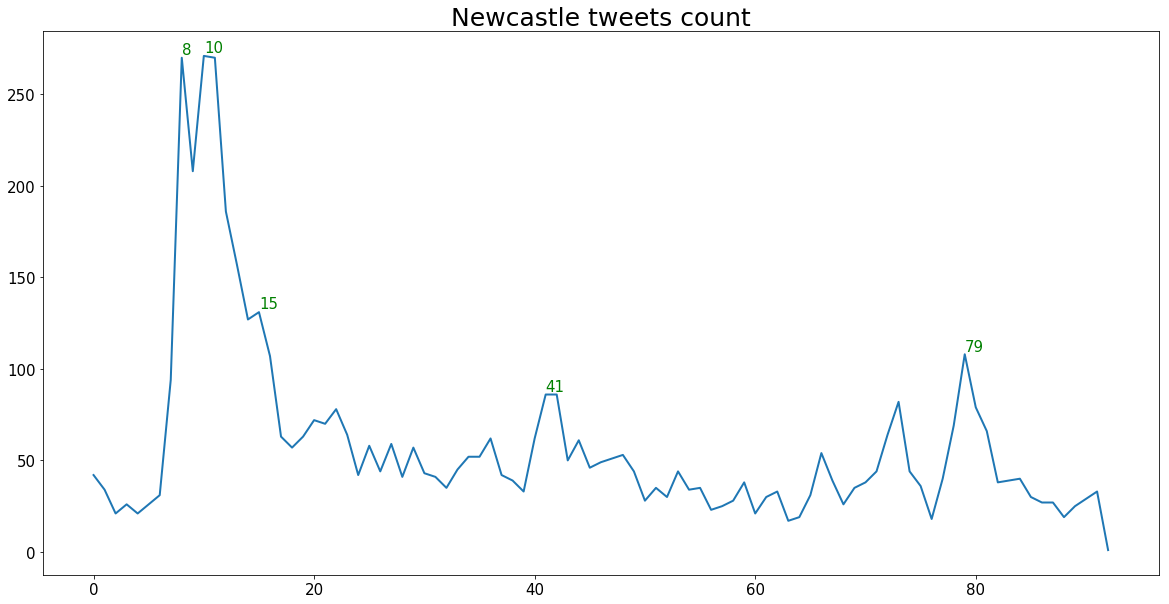

In [22]:
plot_sentiment(team1_count,count_peaks_team1,distance=2,title=team1+" tweets count",filename=team1+'-count.jpg')
plot_sentiment(team2_count,count_peaks_team2,distance=2,title=team2+" tweets count",filename=team2+'-count.jpg')